In [7]:
import pandas as pd

# Load dataset (update the path accordingly)
df = pd.read_csv("sentiment_data.csv")  

# Display first few rows
df.head()


,text,labels
0,"I`d have responded, if I were going",neutral
1,Sooo SAD I will miss you here in San Diego!!!,negative
2,my boss is bullying me...,negative
3,what interview! leave me alone,negative
4,"Sons of ****, why couldn`t they put them on t...",negative


In [8]:
# Check for missing values
print(df.isnull().sum())

# Drop missing values if necessary
df = df.dropna()


text      105
labels      7
dtype: int64


C:\Users\Amey S G\AppData\Local\Temp\ipykernel_15544\3608460911.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='labels', palette='coolwarm')


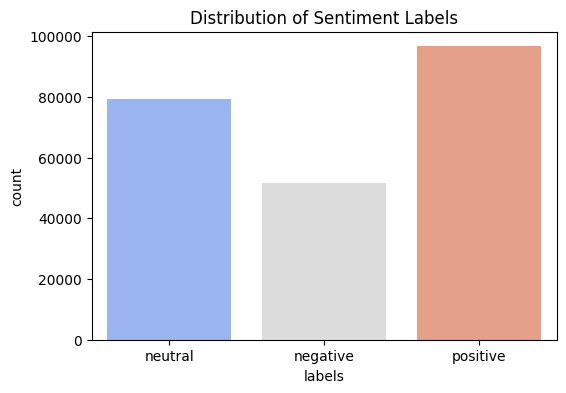

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Check the distribution of stress-related labels
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='labels', palette='coolwarm')
plt.title("Distribution of Sentiment Labels")
plt.show()


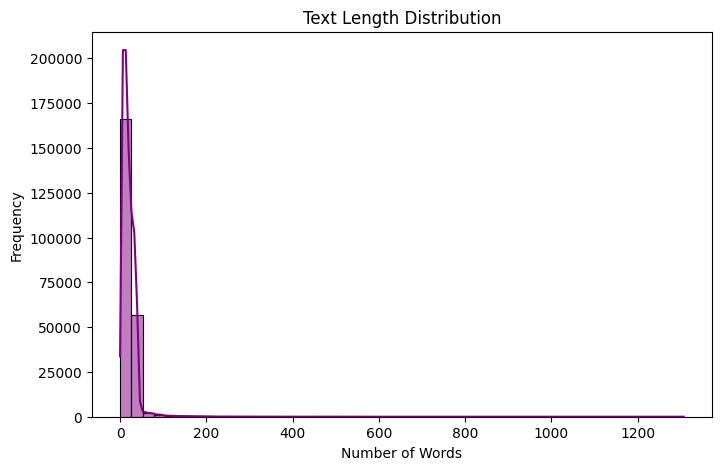

In [10]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate text length
df['text_length'] = df['text'].apply(lambda x: len(x.split()))

# Plot distribution
plt.figure(figsize=(8,5))
sns.histplot(df['text_length'], bins=50, kde=True, color='purple')
plt.title("Text Length Distribution")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()


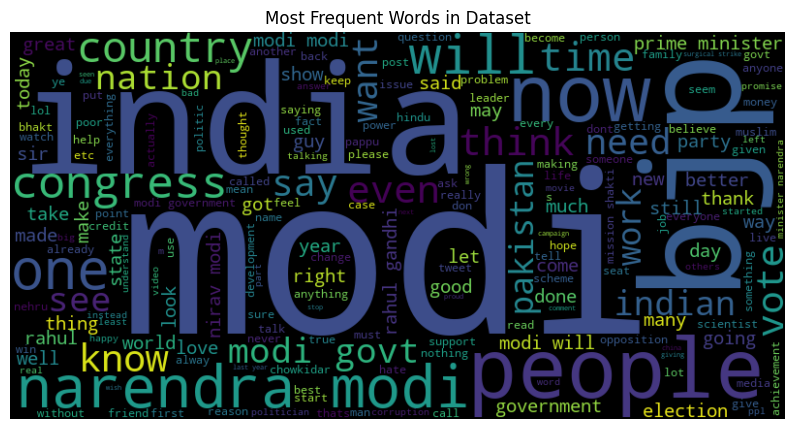

In [11]:
from wordcloud import WordCloud

# Combine all text
all_text = " ".join(df['text'])

# Generate WordCloud
plt.figure(figsize=(10,6))
wordcloud = WordCloud(width=800, height=400, background_color="black").generate(all_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Most Frequent Words in Dataset")
plt.show()

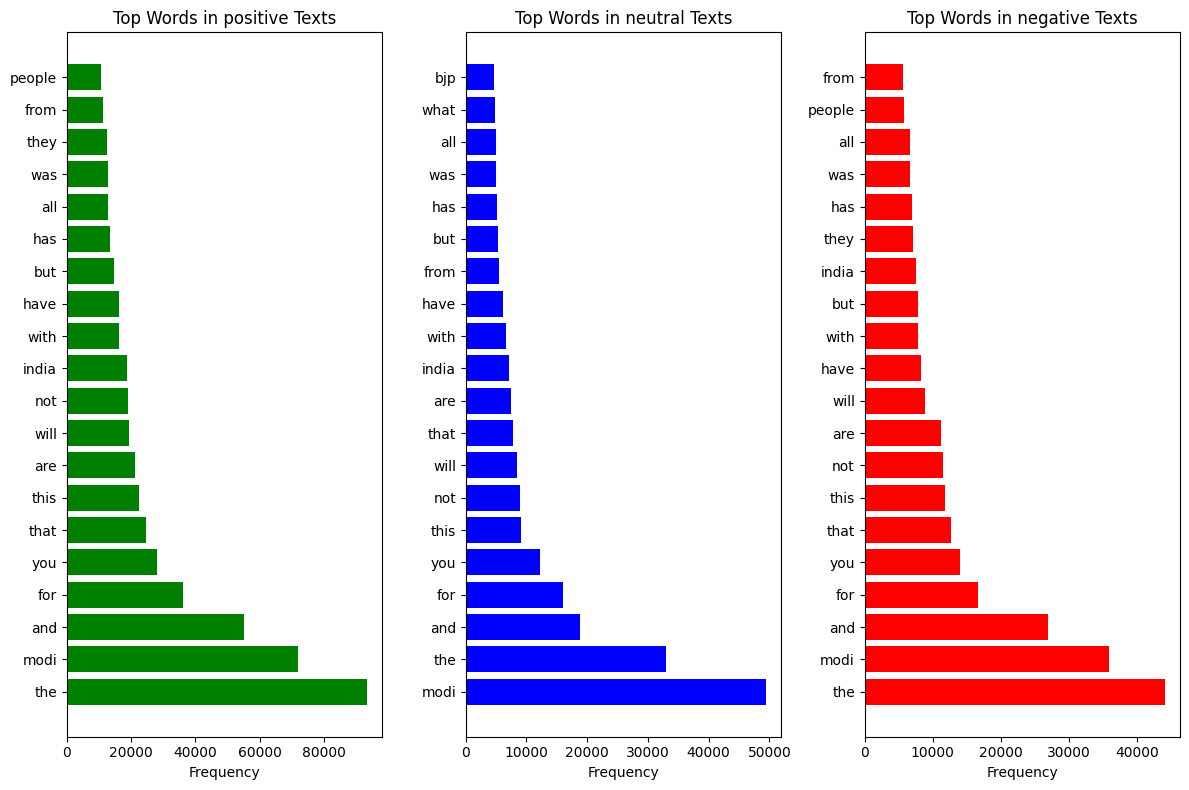

In [6]:
from collections import Counter

def plot_top_words(sentiment_label, color):
    text = " ".join(df[df['labels'] == sentiment_label]['text'])
    words = text.split()
    word_counts = Counter(words).most_common(20)  # Top 20 words
    
    words, counts = zip(*word_counts)
    plt.barh(words, counts, color=color)
    plt.xlabel("Frequency")
    plt.title(f"Top Words in {sentiment_label} Texts")

plt.figure(figsize=(12, 8))

plt.subplot(1,3,1)
plot_top_words('positive', 'green')

plt.subplot(1,3,2)
plot_top_words('neutral', 'blue')

plt.subplot(1,3,3)
plot_top_words('negative', 'red')

plt.tight_layout()
plt.show()

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
import nltk

# Download stopwords if not already available
nltk.download('stopwords')

# Define stopwords set
stop_words = set(stopwords.words('english'))

# Remove stopwords
def remove_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return " ".join(filtered_words)

# Apply stopword removal
df['text'] = df['text'].apply(lambda x: remove_stopwords(str(x)))

# Initialize TF-IDF Vectorizer
vectorizer = TfidfVectorizer(max_features=20)

# Fit and transform the text
tfidf_matrix = vectorizer.fit_transform(df['text'])

# Convert to DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

# Show top features by average TF-IDF score
print("Top TF-IDF Features:")
print(tfidf_df.mean().sort_values(ascending=False))


[nltk_data] Downloading package stopwords to C:\Users\Amey S
[nltk_data]     G\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Top TF-IDF Features:
modi        0.347765
india       0.082614
like        0.049877
bjp         0.048395
people      0.047291
congress    0.039077
one         0.038088
narendra    0.037372
govt        0.030528
time        0.029866
get         0.028326
vote        0.027775
good        0.027624
even        0.026802
country     0.026220
dont        0.025574
know        0.025318
indian      0.025075
also        0.024983
would       0.023454
dtype: float64


In [13]:
from imblearn.over_sampling import SMOTE

X = df['text']  # Features (Assuming text column)
y = df['labels']  # Target labels (Convert to numeric if needed)

# Convert text into numerical form (TF-IDF / Word2Vec before using SMOTE)
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = vectorizer.fit_transform(X)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_tfidf, y)

In [14]:
import joblib
# Save processed data
joblib.dump(X_resampled, "X_resampled.pkl")
joblib.dump(y_resampled, "y_resampled.pkl")
joblib.dump(vectorizer, "tfidf_vectorizer.pkl")

print("✅ Resampled data saved successfully!")

✅ Resampled data saved successfully!


In [2]:
import joblib

# Load resampled data and vectorizer
X_resampled = joblib.load("X_resampled.pkl")
y_resampled = joblib.load("y_resampled.pkl")
vectorizer = joblib.load("tfidf_vectorizer.pkl")

print("✅ Resampled data loaded successfully!")

✅ Resampled data loaded successfully!


C:\Users\Amey S G\AppData\Local\Temp\ipykernel_15544\2083292284.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=resampled_df, x='labels', palette='pastel')


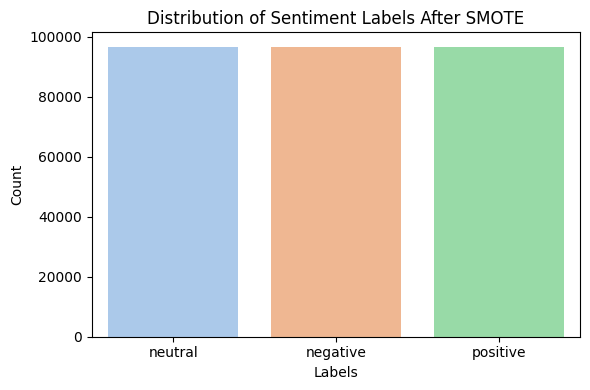

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Create a DataFrame from resampled labels
resampled_df = pd.DataFrame({'labels': y_resampled})

# Plot the class distribution
plt.figure(figsize=(6,4))
sns.countplot(data=resampled_df, x='labels', palette='pastel')
plt.title("Distribution of Sentiment Labels After SMOTE")
plt.ylabel("Count")
plt.xlabel("Labels")
plt.tight_layout()
plt.show()


In [17]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Split the resampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Initialize and train Logistic Regression
lr_model = LogisticRegression(max_iter=500, random_state=42)
lr_model.fit(X_train, y_train)

# Make predictions
y_pred = lr_model.predict(X_test)

# Evaluate model performance
print("✅ Accuracy Score:", accuracy_score(y_test, y_pred))
print("\n📊 Classification Report:\n", classification_report(y_test, y_pred))
print("\n🟦 Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


✅ Accuracy Score: 0.8385088883907789

📊 Classification Report:
               precision    recall  f1-score   support

    negative       0.86      0.77      0.81     19383
     neutral       0.78      0.90      0.84     19317
    positive       0.88      0.84      0.86     19297

    accuracy                           0.84     57997
   macro avg       0.84      0.84      0.84     57997
weighted avg       0.84      0.84      0.84     57997


🟦 Confusion Matrix:
 [[14868  3065  1450]
 [ 1124 17460   733]
 [ 1266  1728 16303]]


In [18]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Split the resampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Initialize and train Naive Bayes (MultinomialNB)
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

# Make predictions
y_pred = nb_model.predict(X_test)

# Evaluate model performance
print("✅ Accuracy Score:", accuracy_score(y_test, y_pred))
print("\n📊 Classification Report:\n", classification_report(y_test, y_pred))
print("\n🟦 Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


✅ Accuracy Score: 0.735434591444385

📊 Classification Report:
               precision    recall  f1-score   support

    negative       0.73      0.77      0.75     19383
     neutral       0.75      0.71      0.73     19317
    positive       0.74      0.73      0.73     19297

    accuracy                           0.74     57997
   macro avg       0.74      0.74      0.74     57997
weighted avg       0.74      0.74      0.74     57997


🟦 Confusion Matrix:
 [[14871  2270  2242]
 [ 2781 13723  2813]
 [ 2829  2409 14059]]


In [19]:
from sklearn.svm import LinearSVC

# Initialize and train Linear SVM
svm_model = LinearSVC(C=1.0, random_state=42)
svm_model.fit(X_train, y_train)

# Make predictions
y_pred = svm_model.predict(X_test)

# Evaluate model performance
print("✅ Accuracy Score:", accuracy_score(y_test, y_pred))
print("\n📊 Classification Report:\n", classification_report(y_test, y_pred))
print("\n🟦 Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


✅ Accuracy Score: 0.8375260789351173

📊 Classification Report:
               precision    recall  f1-score   support

    negative       0.87      0.76      0.81     19383
     neutral       0.78      0.91      0.84     19317
    positive       0.88      0.85      0.86     19297

    accuracy                           0.84     57997
   macro avg       0.84      0.84      0.84     57997
weighted avg       0.84      0.84      0.84     57997


🟦 Confusion Matrix:
 [[14652  3323  1408]
 [  954 17581   782]
 [ 1209  1747 16341]]


✅ Accuracy Score: 0.8415

📊 Classification Report:
               precision    recall  f1-score   support

    negative       0.86      0.78      0.82     19332
     neutral       0.79      0.91      0.85     19332
    positive       0.88      0.84      0.86     19333

    accuracy                           0.84     57997
   macro avg       0.84      0.84      0.84     57997
weighted avg       0.84      0.84      0.84     57997


🔥 ROC-AUC Score: 0.939


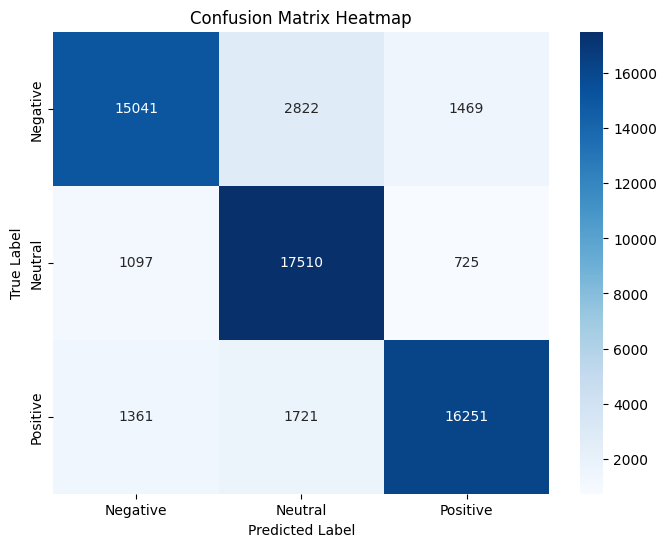

In [7]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, roc_auc_score
)

# Feature scaling for better convergence (Set with_mean=False for sparse data)
scaler = StandardScaler(with_mean=False)
X_resampled_scaled = scaler.fit_transform(X_resampled)

# Split the resampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled_scaled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

# Initialize and train Logistic Regression with balanced class weights
lr_model = LogisticRegression(
    max_iter=1000, random_state=42, class_weight="balanced"
)
lr_model.fit(X_train, y_train)

# Make predictions
y_pred = lr_model.predict(X_test)

# Evaluate model performance
print("✅ Accuracy Score:", round(accuracy_score(y_test, y_pred), 4))
print("\n📊 Classification Report:\n", classification_report(y_test, y_pred))

# Calculate ROC-AUC for multi-class classification using "ovr" (One-vs-Rest)
print("\n🔥 ROC-AUC Score:", round(roc_auc_score(y_test, lr_model.predict_proba(X_test), multi_class="ovr"), 4))

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix as heatmap (Without emoji to avoid glyph error)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title("Confusion Matrix Heatmap")  # 🔥 Emoji Removed to Avoid Warning
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [15]:
# ✅ Function to predict user input
def predict_user_input(user_text, vectorizer, scaler, lr_model):
    # Preprocess the text using the same vectorizer
    text_vectorized = vectorizer.transform([user_text])

    # Scale the data using the same scaler
    text_scaled = scaler.transform(text_vectorized)

    # Make prediction
    prediction = lr_model.predict(text_scaled)[0]  # This is the actual label (string or int)
    prediction_proba = lr_model.predict_proba(text_scaled)

    # Show the results
    print(f"\n📝 Input Text: {user_text}")
    print(f"✅ Predicted Sentiment: {prediction}")
    print(f"🔎 Prediction Probabilities: {prediction_proba}")

In [16]:
predict_user_input("I love this product!", vectorizer, scaler, lr_model)


📝 Input Text: I love this product!
✅ Predicted Sentiment: positive
🔎 Prediction Probabilities: [[0.00196078 0.03273387 0.96530535]]


In [17]:
predict_user_input("I feel sad today.", vectorizer, scaler, lr_model)


📝 Input Text: I feel sad today.
✅ Predicted Sentiment: negative
🔎 Prediction Probabilities: [[9.98738493e-01 1.26114843e-03 3.58473315e-07]]


In [22]:
predict_user_input("I am not sure about this.", vectorizer, scaler, lr_model)


📝 Input Text: I am not sure about this.
✅ Predicted Sentiment: neutral
🔎 Prediction Probabilities: [[0.29115939 0.69994647 0.00889415]]


In [23]:
predict_user_input("I am feeling great!", vectorizer, scaler, lr_model)


📝 Input Text: I am feeling great!
✅ Predicted Sentiment: positive
🔎 Prediction Probabilities: [[0.00306914 0.29781765 0.69911322]]


In [24]:
predict_user_input("I am feeling terrible.", vectorizer, scaler, lr_model)


📝 Input Text: I am feeling terrible.
✅ Predicted Sentiment: negative
🔎 Prediction Probabilities: [[9.99842874e-01 1.57105118e-04 2.05158244e-08]]
